# Classification with Random Forest Classifier  

After cleaning and analysing the dataset we proceed with a classifier, which is carried on with the random forest classifier algorithm

![random-forest.jpg](random-forest.jpg)

## Preparing the data 

We import the relevant libraries from ScikitLearn

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

We import the data from `TWER_grouped_class.csv`:

In [2]:
df = pd.read_csv('../data/processed/TWER_grouped_class.csv').drop('Unnamed: 0', axis=1)

In [3]:
df.head()

,date,municipality.name,hour_category,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,curr_site,population,elevation,tweet_count,month,day,day_of_week,class
0,2013-11-01,Andalo,A,9.200000,8.5,12.000000,0.0,NaN,NaN,0.000000,0.000000,1024.0,1042.0,1,11,1,4,Low
1,2013-11-01,Baselga di Pinè,B,11.533333,8.0,13.733333,0.0,0.2,236.0,5.996413,0.016458,4928.0,964.0,3,11,1,4,Medium
2,2013-11-01,Baselga di Pinè,C,11.433333,7.3,12.966667,0.0,0.0,184.0,10.637787,0.017426,4928.0,964.0,3,11,1,4,Medium
3,2013-11-01,Baselga di Pinè,D,9.350000,6.6,12.200000,0.0,NaN,NaN,18.809585,0.024556,4928.0,964.0,2,11,1,4,Medium
4,2013-11-01,Bedollo,B,14.120000,8.7,14.500000,0.0,0.3,232.5,0.383955,0.015358,1476.0,1059.0,5,11,1,4,Medium


Before continuing, we need to remove the last day (2013-12-31), on which we will make the prediction.

In [4]:
df = df[df['day'] != 31]

Let's divide `df` into features and target:

In [5]:
X = df.drop('class', axis=1)
y = df['class']  # target is the multi-class label (High, Medium, Low)

### Preprocessing

We now preprocess the data. 
The classifier only really accepts numbers as an input, so string-to-number conversion of categorical data is essential.
Since this process only concerns categorical data,  we need to split numerical and categorical features first. Second, we enconde the categorical data with label encoding. 

Now we prepare for the classification by splitting Train Data and Test Data. We want the test data to be the 20% of the data available (test_size=0.2) and we want to fix a random_state value of 20.

This is basically like a seed and assures the "random behaviour" of the forest, to be always the same if we run the program the program multiple times.

In the fase of tuning repeatability is essential, because it is the only way to reliably tune the parameters of the model. 

We then scale the numerical features, convert them back to dataframe form and finally recombine categorical and numerical data

In [6]:
X.columns

Index(['date', 'municipality.name', 'hour_category', 'temperature',
       'minTemperature', 'maxTemperature', 'precipitation', 'wind_speed',
       'wind_dir', 'curr_cell', 'curr_site', 'population', 'elevation',
       'tweet_count', 'month', 'day', 'day_of_week'],
      dtype='object')

In [7]:
def preprocess_data(X, y, categorical_features, numerical_features, test_size=0.2, random_state=20):
    # Label encode the target
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)

    # Label encode categorical features
    le_feature = LabelEncoder()
    for feat in categorical_features:
        X[feat] = le_feature.fit_transform(X[feat])

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Scale numerical features
    scaler = StandardScaler()
    X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])

    return X_train, X_test, y_train, y_test


We then initialise and train the classifier. 

In [8]:
def train_and_evaluate(X_train, X_test, y_train, y_test, n_estimators, max_depth=None):
    # Initialize Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=20)
    
    # Train the classifier
    rf_classifier.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_classifier.predict(X_test)
    
    # Print results
    print(f"Accuracy with n_estimators={n_estimators} and max_depth={max_depth}: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    ax = plt.subplot()
    sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
    ax.xaxis.set_ticklabels(['high', 'low', 'medium'])
    ax.yaxis.set_ticklabels(['high', 'low', 'medium'])
    plt.show()
    
    return conf_matrix

In the developement of our analysis we noticed that it was not obvious whether to use all the data we had available or just a part of that. 

We intend to discuss this matter by examining two data sets: one that basically trains exlusively on tweet counts and the ARPA's weather data and the other on the largest possible dataset, which also has electrical data and other potentially meaningful features such as `population`, `elevation`. Naturally these data appear with their relative time slot and municipality. 

We do the traing for both dataset with respectively a little forest `(n_estimators=4, max_depth=4)` and a large forest `(n_estimators=100, no max_depth)`. 
In order to do that we created a function that will execute, with any given parameter, all the steps of our classification. 

Indeed the function:
1) Splits the data set in training and test data 
2) Trains the Classifier 
3) Commutes the prediction
4) Prints all the meaningful extimators
5) Plots the confusion matrix and the heatmap 

We create the two relevant Dataframes : 

In [9]:
# Dataset 1 (weather data)
X_weather = df.drop('class', axis=1).drop(['curr_cell', 'curr_site', 'population', 'elevation'], axis=1)
y_weather = df['class']

# Categorical and numerical features
categorical_features_weather = ['date', 'municipality.name', 'hour_category', 'month', 'day_of_week']
numerical_features_weather = ['temperature', 'minTemperature', 'maxTemperature', 'precipitation', 'wind_speed', 'wind_dir', 'tweet_count', 'day']

# Preprocess Dataset 1
X_weather_train, X_weather_test, y_weather_train, y_weather_test = preprocess_data(X_weather, y_weather, categorical_features_weather, numerical_features_weather)

In [10]:
# Dataset 2 (weather + other)
X_additional = df.drop('class', axis=1)
y_additional = df['class']

# Categorical and numerical features
categorical_features_additional = ['date', 'municipality.name', 'hour_category', 'month', 'day_of_week']
numerical_features_additional = ['temperature', 'minTemperature', 'maxTemperature', 'precipitation', 'wind_speed', 'wind_dir', 
                                 'curr_cell', 'population', 'elevation', 'curr_site', 'tweet_count', 'day']

# Preprocess Dataset 2
X_additional_train, X_additional_test, y_additional_train, y_additional_test = preprocess_data(X_additional, y_additional, categorical_features_additional, numerical_features_additional)

## RF classification

We herby presents all the different scenarios 

Scenario 1: Weather Data with n_estimators=4 and max_depth=4
Accuracy with n_estimators=4 and max_depth=4: 0.958974358974359
              precision    recall  f1-score   support

           0       0.80      0.11      0.19        37
           1       0.99      1.00      0.99       441
           2       0.93      0.99      0.96       497

    accuracy                           0.96       975
   macro avg       0.91      0.70      0.71       975
weighted avg       0.95      0.96      0.95       975



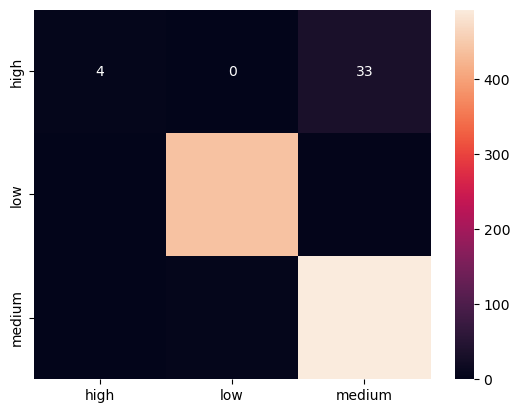

In [11]:
print("Scenario 1: Weather Data with n_estimators=4 and max_depth=4")
conf_matrix1 = train_and_evaluate(X_weather_train, X_weather_test, y_weather_train, y_weather_test, n_estimators=4, max_depth=4)

Scenario 2: Weather + Additional Data with n_estimators=4 and max_depth=4
Accuracy with n_estimators=4 and max_depth=4: 0.9866666666666667
              precision    recall  f1-score   support

           0       1.00      0.65      0.79        37
           1       1.00      1.00      1.00       441
           2       0.97      1.00      0.99       497

    accuracy                           0.99       975
   macro avg       0.99      0.88      0.92       975
weighted avg       0.99      0.99      0.99       975



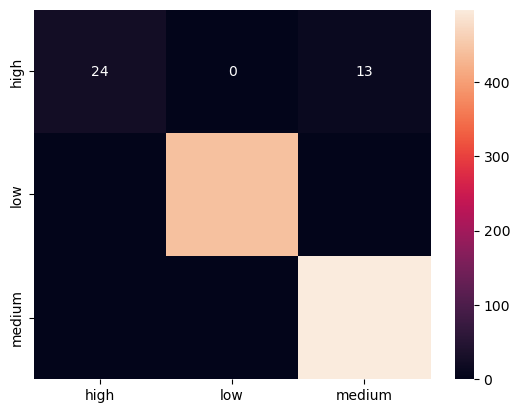

In [12]:
print("Scenario 2: Weather + Additional Data with n_estimators=4 and max_depth=4")
conf_matrix2 = train_and_evaluate(X_additional_train, 
                                  X_additional_test, 
                                  y_additional_train, 
                                  y_additional_test, 
                                  n_estimators=4, 
                                  max_depth=4)

Scenario 3: Weather Data with n_estimators=100 and no max_depth
Accuracy with n_estimators=100 and max_depth=None: 0.9969230769230769
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        37
           1       1.00      1.00      1.00       441
           2       0.99      1.00      1.00       497

    accuracy                           1.00       975
   macro avg       1.00      0.97      0.98       975
weighted avg       1.00      1.00      1.00       975



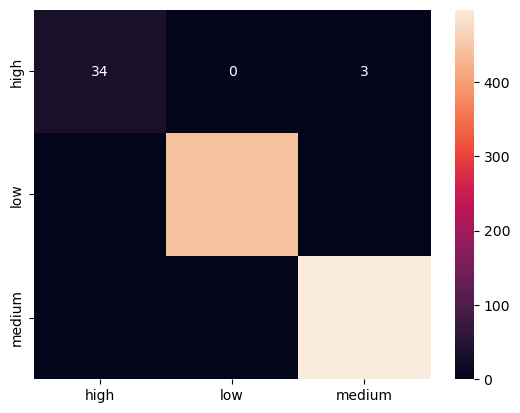

In [13]:
print("Scenario 3: Weather Data with n_estimators=100 and no max_depth")
conf_matrix3 = train_and_evaluate(X_weather_train, 
                                  X_weather_test,
                                  y_weather_train, 
                                  y_weather_test,
                                  n_estimators=100, 
                                  max_depth=None)

Scenario 4: Weather + Additional Data with n_estimators=100 and no max_depth
Accuracy with n_estimators=100 and max_depth=None: 0.997948717948718
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        37
           1       1.00      1.00      1.00       441
           2       1.00      1.00      1.00       497

    accuracy                           1.00       975
   macro avg       1.00      0.98      0.99       975
weighted avg       1.00      1.00      1.00       975



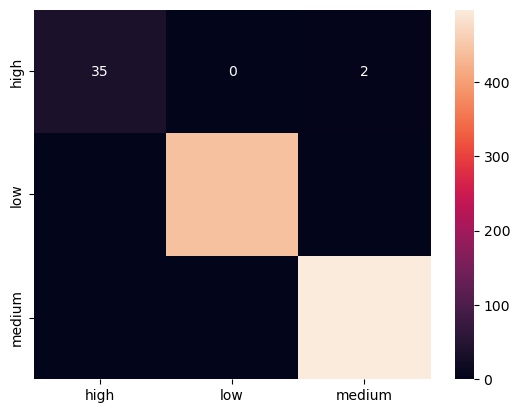

In [14]:
print("Scenario 4: Weather + Additional Data with n_estimators=100 and no max_depth")
conf_matrix4 = train_and_evaluate(X_additional_train,
                                  X_additional_test,
                                  y_additional_train,
                                  y_additional_test,
                                  n_estimators=100, 
                                  max_depth=None)

This result is not obvious, the so called additional data are not correlated as well to tweet count as the whether data, the risk of redundancy or even insignificance of the dataset is high. Indeed from a first trial it seemed to us the results went in this direction. The risk of overfitting for a larger dataset is high if there are redundancies, since the model may overlearn patterns. If the "additional data" introduces noise instead of information, it's better to remove that part of the dataset entirely. 

Nevertheless, we notice a neat improvement by introducing new data and this signals that the additional data is indeed informative. 

Beyond that, what we notice is that little forests perform way worse than larger forests, a more in depth  training and a meaningful number of estimators is crucial to generalisation. 
This does not depend on the dataset but it is very general, the eventual point in setting a low number of estimators and max_depth parameter is to make the training computationally feasible, but for us it's no problem since the whole process is very fast. If we were to analyse the telecommunication data, the correct approach may very well be using low max_depth and low n_estimators. 

As indicated by the the accuracy, the classifier always works fine, even in the little forest case. 
In the last case (larger forest on larger dataset), we see the promising result of just one misclassification.

We point out that, as emerges form the confusion matrix, the error type is (almost) always the same in the four cases: some municipalities, which are predicted to be in the middle tweet count range, actually end up to be in the high tweet count range.

This makes sense, because, whereas there are not many events outside our dataset which can cause great short term depression in the tweet count, there are lots of social events that may cause an occasional peak in the tweet count. In the dates Dec 13th and 14th 2013, which present the greatest tweet predictive mistake, a big event called **Universiadi** was held in the municipality of Trento, where such peak is registered.

## Prediction

Now that we estalished the validity of our model, we can train it on all data before December 31st, the day of the prediction.

In [15]:
df = pd.read_csv('../data/processed/TWER_grouped_class.csv').drop('Unnamed: 0', axis=1)

In [16]:
df.head()

,date,municipality.name,hour_category,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,curr_site,population,elevation,tweet_count,month,day,day_of_week,class
0,2013-11-01,Andalo,A,9.200000,8.5,12.000000,0.0,NaN,NaN,0.000000,0.000000,1024.0,1042.0,1,11,1,4,Low
1,2013-11-01,Baselga di Pinè,B,11.533333,8.0,13.733333,0.0,0.2,236.0,5.996413,0.016458,4928.0,964.0,3,11,1,4,Medium
2,2013-11-01,Baselga di Pinè,C,11.433333,7.3,12.966667,0.0,0.0,184.0,10.637787,0.017426,4928.0,964.0,3,11,1,4,Medium
3,2013-11-01,Baselga di Pinè,D,9.350000,6.6,12.200000,0.0,NaN,NaN,18.809585,0.024556,4928.0,964.0,2,11,1,4,Medium
4,2013-11-01,Bedollo,B,14.120000,8.7,14.500000,0.0,0.3,232.5,0.383955,0.015358,1476.0,1059.0,5,11,1,4,Medium


In [17]:
X = df.drop('class', axis=1)
y = df['class']

In [18]:
categorical_features = ['date', 'municipality.name', 'hour_category', 'month', 'day_of_week']  # Any string or categorical features
numerical_features = ['temperature', 
                      'minTemperature', 
                      'maxTemperature', 
                      'precipitation', 
                      'wind_speed',
                      'wind_dir',
                      'curr_cell',
                      'population',
                      'elevation',
                      'tweet_count',
                      'curr_site',
                      'day']

In [19]:
# Selecting Dec 31st
len31 = len(X[X['date'] == '2013-12-31'])

Now the train-test split is done by selecting only the days before Dec 31st.

/var/folders/96/_x5hcfwd0qd065qkfnngc6bh0000gn/T/ipykernel_68551/3193346658.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
/var/folders/96/_x5hcfwd0qd065qkfnngc6bh0000gn/T/ipykernel_68551/3193346658.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        95

    accuracy                           1.00       159
   macro avg       1.00      1.00      1.00       159
weighted avg       1.00      1.00      1.00       159



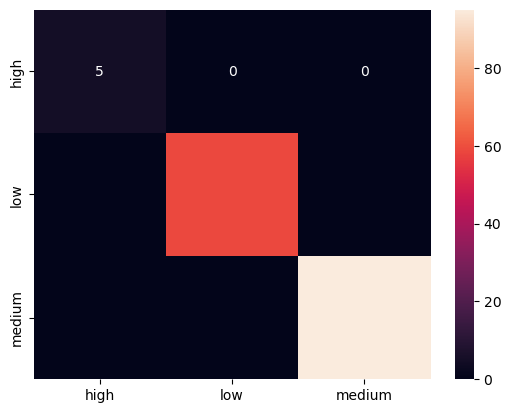

In [21]:
# 1. Label encoding for categorical features and target
le = LabelEncoder()
y = le.fit_transform(y)  # Apply LabelEncoder to the entire target variable

# Encode the categorical features for the entire dataset before splitting
for feat in categorical_features:
    X[feat] = le.fit_transform(X[feat])

# 2. Split the dataset after label encoding
X_train, X_test = X[0:len(X)-len31], X[len(X)-len31:]
y_train, y_test = y[0:len(X)-len31], y[len(X)-len31:]

# 3. Scale numerical features after splitting
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Training the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=20)
rf_classifier.fit(X_train, y_train)

# Predicting and evaluating
y_pred = rf_classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
ax.xaxis.set_ticklabels(['high', 'low', 'medium'])
ax.yaxis.set_ticklabels(['high', 'low', 'medium'])
plt.show()

That's what we wanted.